In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from random import randint
import math

In [2]:
def rand():#generate random number, should have same range as in C
    return randint(0,2147483647)

## Initialize and generate parameters

In [3]:
max_neuron_num = 1000
# length = num_of_neuron.bit_length()
s1 = []#coprime with integers from 3 to num_of_neuron
s2 = []#multiplicative inverses

In [4]:
def gen_secret_arrays():
    i = 3
    while i <= max_neuron_num:
        r = randint(0,i)
        if math.gcd(r,i) == 1:
            s1.append(r)
            s2.append(pow(r,-1,i))#multiplicative inverse
            i = i+1
#     print(s1)
#     print(s2)
    return

gen_secret_arrays()

## Funtion definitions

In [5]:
#Blakely's method for computing a*b mod n
def Blakely(a,b,n):
    R = 0
    length = a.bit_length()
    for i in range(length-1,-1,-1):
        ai = (a >> i) & 1
        R = 2*R + ai*b
        if R >= n:
            R = R -n
        if R >= n:
            R = R -n
    return R

In [6]:
def modulo_masked(i):
    r1 = rand()
    r2 = rand()
    tmp = (r1* s1[i-2] + r2*(i+1))%(i+1)
    
#     j = (tmp*s2[i])%(i+1)
    j = Blakely(tmp,s2[i-2],i+1)
    
    ###test if it is the same as un-masked value
    j2 = r1%(i+1)
    if(j2 != j):
        print("not equal " + str(i))
    return j

In [7]:
def Fisher_Yates (arr, size):
    for i in range(size-1,0,-1):
        j = rand()%(i+1)
 
        arr[i],arr[j] = arr[j],arr[i]
    return arr

In [8]:
def Fisher_Yates_masked (arr, size):
    
    for i in range(size-1,1,-1):
        j = modulo_masked(i)
        arr[i],arr[j] = arr[j],arr[i]
    
    j = rand()%2
    arr[1],arr[j] = arr[j],arr[1]
    
    return arr

## Testing

In [9]:
def test_Blakely():
    for a in range(max_neuron_num):
        for b in range(max_neuron_num):
            pro = Blakely(a,b,max_neuron_num)
            pro2 = (a*b)%max_neuron_num
            if pro2 != pro:
                print(str(pro) + ", " + str(pro2))
    return
# test_Blakely()

In [10]:
for i in range(max_neuron_num-1,1):
    modulo_masked(i)

In [11]:
# arr = [i for i in range(max_neuron_num)]
# print(Fisher_Yates(arr, max_neuron_num))
# print(Fisher_Yates_masked(arr, max_neuron_num))

## Overhead compared to original shuffling

In [12]:
def compute_overhead(num_of_neuron):
    arr = [i for i in range(num_of_neuron)]
    start_time = time.time()
    Fisher_Yates(arr, num_of_neuron)
    end_time = time.time()

    start_time_masked = time.time()
    Fisher_Yates_masked(arr, num_of_neuron)
    end_time_masked = time.time()

    t = end_time - start_time
    t_masked = end_time_masked - start_time_masked
    overhead = ((t_masked - t)/t)*100

#     print(t_masked)
#     print(t)
#     print(overhead)
    return overhead

In [13]:
def average_overhead(number_of_runs, num_of_neuron):
    overhead = 0
    for i in range(number_of_runs):
        overhead += compute_overhead(num_of_neuron)
    overhead /= number_of_runs
    print(overhead)
    return

In [14]:
average_overhead(100, 100)

236.80950034959488


In [15]:
average_overhead(1000, 1000)

307.10239527700486


### Results:
1000 neurons: 338.8710487295949, 100 neurons: 248.00801308417056

# Overhead over unprotected one layer computation

In [16]:
# Define the ReLU function
def relu(x):
    """
    Rectified Linear Unit (ReLU) activation function.
    Args:
    x (float or np.ndarray): Input to the ReLU function.
    Returns:
    float or np.ndarray: Output after applying ReLU.
    """
    return np.maximum(0, x)

In [17]:
def one_layer(inputs, W, hidden_layer_neuron, num_of_neuron):
    outputs = [0 for i in range(hidden_layer_neuron)]
    for i in range(hidden_layer_neuron):
        for j in range(num_of_neuron):
            outputs[i] += (W[i,j]*inputs[j])
        outputs[i] = relu(outputs[i])
    return outputs

In [18]:
def shuffled_one_layer(inputs, W,hidden_layer_neuron, num_of_neuron):
    indices = [i for i in range(num_of_neuron)]
    new_indices = Fisher_Yates_masked(indices, num_of_neuron)
    outputs = [0 for i in range(hidden_layer_neuron)]
    for i in range(hidden_layer_neuron):
        for j in range(num_of_neuron):
            outputs[i] += (W[i,new_indices[j]]*inputs[new_indices[j]])
        outputs[i] = relu(outputs[i])
    return outputs

In [19]:
def overhead_multiple_layer_over_unprotected(no_of_neurons, no_of_layers):
    
    inputs = [random.uniform(-10, 10) for i in range(no_of_neurons)] #random input values
    inputs = np.array(inputs)
    weights = [[] for i in range(no_of_layers)]

    for i in range(no_of_layers):
        W = [[random.uniform(-10, 10) for i in range(no_of_neurons)] for j in range(no_of_neurons)]#random weight values
        weights[i]= W
    
    weights = np.array(weights)

    start_time = time.time()
    layer_inputs = inputs
    for i in range(no_of_layers):
        outputs1 = one_layer(layer_inputs, weights[i], no_of_neurons, no_of_neurons)
        layer_inputs = outputs1
    end_time = time.time()
    
#     print("original output:")
#     print(outputs1)

    start_time_masked = time.time()
    layer_inputs = inputs
    for i in range(no_of_layers):
         outputs2 = shuffled_one_layer(layer_inputs, weights[i], no_of_neurons, no_of_neurons)
         layer_inputs = outputs2
    end_time_masked = time.time()
    
#     print("output with countermeasure:")
#     print(outputs2)

    t = end_time - start_time
    t_masked = end_time_masked - start_time_masked
    overhead = ((t_masked - t)/t)*100
    

    return overhead

In [20]:
def average_overhead_multiple_layers_unprotected(number_of_runs, no_of_neurons, no_of_layers):
    overhead = 0
    for i in range(number_of_runs):
        overhead += overhead_multiple_layer_over_unprotected(no_of_neurons, no_of_layers)
    overhead /= number_of_runs
    print(overhead)
    return overhead

In [22]:
average_overhead_multiple_layers_unprotected(100,100,1)

7.3499802376880075


7.3499802376880075

In [28]:
def plot_graph_multiple_layers_unprotected(number_of_runs, total_layers):
    
    nums = [j for j in range(50,1001,50)]
    length = len(nums)#number of rows in the output file

    for no_of_layers in range(total_layers-1,total_layers):
        print("Computing overhead for " + str(no_of_layers) + " layers")
        results = []
        for no_of_neurons in nums:
            if(no_of_neurons%100==0):
                print("running for " + str(no_of_neurons) + " neurons")
            overhead = average_overhead_multiple_layers_unprotected(number_of_runs, no_of_neurons, no_of_layers)
            results.append(overhead)

        f = open("overhead_unprotected" + str(no_of_layers) + ".txt", "w")
    
        #first line
        f.write("x y\n")
        
        for i in range(length):#for each row
            f.write(str(nums[i])+ " " + str(results[i]) + "\n")
        f.close()
        
        plt.plot(nums,results, color="r")
        
    return

Computing overhead for 1 layers
10.420568914326333
running for 100neurons
7.900933066749627
6.011807276863165
running for 200neurons
4.2969086918284445
5.258871524360713
running for 300neurons
5.593519841940831
5.298508683731802
running for 400neurons
3.939270085407614
6.011948487541554
running for 500neurons
4.882745091796332
5.079907397799771
running for 600neurons
3.8723670218290582
4.900667625592542
running for 700neurons
3.705953808428069
5.292404468246392
running for 800neurons
5.354692842140938
4.106022552932339
running for 900neurons
4.566308620599122
4.016610546337212
running for 1000neurons
5.40178497365257


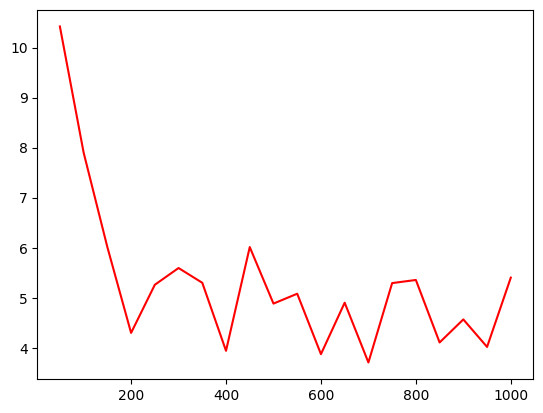

In [29]:
plot_graph_multiple_layers_unprotected(100, 2)

Computing overhead for 4 layers
13.643597913546389
running for 100neurons
9.332498495070498
7.6646406680296595
running for 200neurons
6.43773863017891
6.215709902165819
running for 300neurons
6.611941105822626
6.0926145886825545
running for 400neurons
7.7506758370242075
7.250595729200879
running for 500neurons
6.585652880398673
6.72398471225377
running for 600neurons
6.5532537814330984
6.2931577777945575
running for 700neurons
5.837006423761138
6.247830718463513
running for 800neurons
5.769565708116785
5.1635689766039174
running for 900neurons
5.8146825572364165
5.448566180432882
running for 1000neurons
5.109747220251153


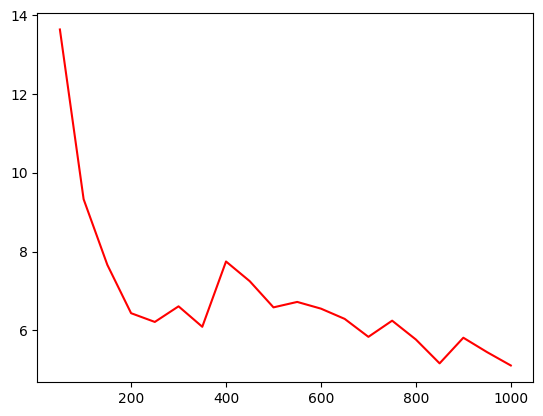

In [30]:
plot_graph_multiple_layers_unprotected(100, 5)

Computing overhead for 2 layers
13.089939074881388
running for 100neurons
8.481570591500295
7.084667635890705
running for 200neurons
6.170143001693084
8.03455850056676
running for 300neurons
6.301934349247755
5.802899228173362
running for 400neurons
7.147502424076613
6.655382018519036
running for 500neurons
6.546020003069024
5.009321358968645
running for 600neurons
6.556674000397934
6.699856475740807
running for 700neurons
5.801549107404689
5.999860675436549
running for 800neurons
7.098279754341563
6.105552674963667
running for 900neurons
5.455685200892528
5.689578756582481
running for 1000neurons
5.991471698895498


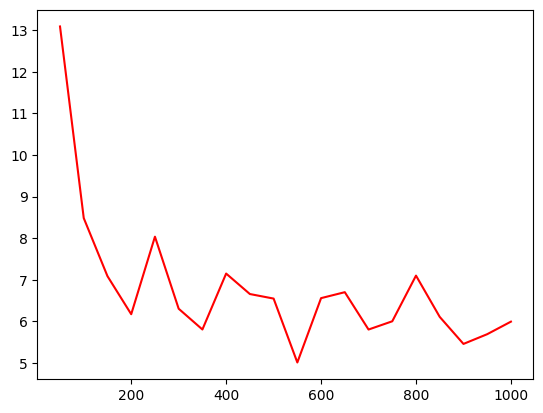

In [32]:
plot_graph_multiple_layers_unprotected(100, 3)

Computing overhead for 3 layers
12.955570636749187
running for 100neurons
8.707696030995447
7.363380089729329
running for 200neurons
6.275512279610971
6.11574942648714
running for 300neurons
6.561971822884988
5.012444345791858
running for 400neurons
7.614695307983854
7.1369815760292
running for 500neurons
6.662938272277659
7.287851316789773
running for 600neurons
6.429261096398547
7.256449238082906
running for 700neurons
6.289679035221761
6.1034984600712425
running for 800neurons
6.414682238224965
6.39705213726947
running for 900neurons
5.823017370692722
5.438929780254849
running for 1000neurons
6.291394810466604


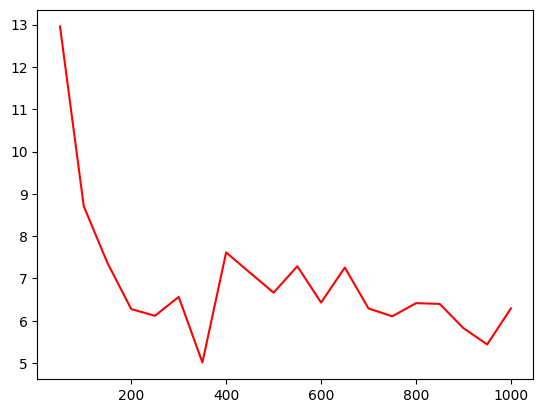

In [33]:
plot_graph_multiple_layers_unprotected(100, 4)

Computing overhead for 20 layers
16.39784037430281
running for 100neurons
9.529870583895224
8.018981489785663
running for 200neurons
6.978124492525947
6.603511087349897
running for 300neurons
7.1885585434162715
7.470935195945806
running for 400neurons
8.618919607485964
7.4273904472283565
running for 500neurons
7.8356745707572175
9.36882946130736
running for 600neurons
7.530972321726011
6.767065801721035
running for 700neurons
7.927758211472659
6.629165331528053
running for 800neurons
7.202102777032622
6.868257091810988
running for 900neurons
6.4645788198562135
5.7178529939312215
running for 1000neurons
6.169770850036066


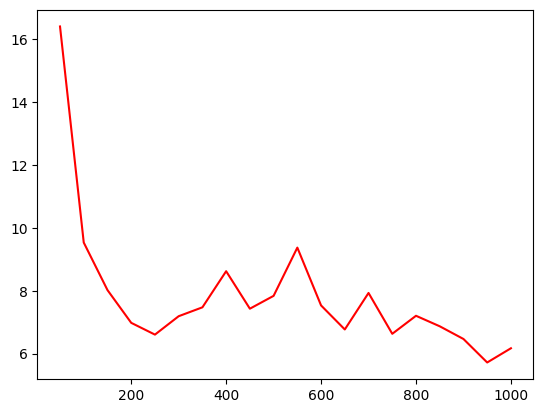

In [34]:
plot_graph_multiple_layers_unprotected(100, 21)

# Overhead over original shuffling with one layer computation

In [8]:
def Fisher_shuffled_one_layer(inputs, W, hidden_layer_neuron, num_of_neuron):
    indices = [i for i in range(num_of_neuron)]
    new_indices = Fisher_Yates(indices, num_of_neuron)
    outputs = [0 for i in range(hidden_layer_neuron)]
    for i in range(hidden_layer_neuron):
        for j in range(num_of_neuron):
            outputs[i] += (W[i,new_indices[j]]*inputs[new_indices[j]])
        outputs[i] = relu(outputs[i])
    return outputs

In [9]:
def overhead_over_layer(hidden_layer_neuron, num_of_neuron):
    
    inputs = [random.uniform(-10, 10) for i in range(num_of_neuron)] #random input values
    W = [[random.uniform(-10, 10) for i in range(num_of_neuron)] for j in range(hidden_layer_neuron)]#random weight values
    inputs = np.array(inputs)
    W = np.array(W)

    start_time = time.time()
    outputs1 = Fisher_shuffled_one_layer(inputs, W, hidden_layer_neuron, num_of_neuron)
    end_time = time.time()
    
#     print("original output:")
#     print(outputs1)

    start_time_masked = time.time()
    outputs2 = shuffled_one_layer(inputs, W,hidden_layer_neuron, num_of_neuron)
    end_time_masked = time.time()
    
#     print("output with countermeasure:")
#     print(outputs2)

    t = end_time - start_time
    t_masked = end_time_masked - start_time_masked
    overhead = ((t_masked - t)/t)*100
    

    return overhead

In [10]:
def average_overhead(number_of_runs, hidden_layer_neuron, num_of_neuron):
    overhead = 0
    for i in range(number_of_runs):
        overhead += overhead_over_layer(hidden_layer_neuron, num_of_neuron)
    overhead /= number_of_runs
    print(overhead)
    return overhead

In [63]:
average_overhead(100,100,100)

4.24601115217238


4.24601115217238

In [64]:
average_overhead(100,1000,1000)

0.706200796959108


0.706200796959108

### Results
100 input neurons, 100 hidden layer neurons, overhead = 3.7598244750900722

1000 input neurons, 1000 hidden layer neurons, overhead = 0.8444497612610407

In [11]:
def plot_graph(number_of_runs):
    results = []
    nums = [j for j in range(50,1001,50)]
    
    for num_of_neuron in nums:
        overhead = average_overhead(number_of_runs, num_of_neuron, num_of_neuron)
        results.append(overhead)
        
    f = open("overhead.txt", "w")
    length = len(nums)#number of rows
    
    
    #first line
    f.write("x y\n")
    
    for i in range(length):#for each row
        f.write(str(nums[i])+ " " + str(results[i]) + "\n")
    f.close()
    
    plt.plot(nums,results, color="r")
    return

8.008566543895299
3.998813734119878
3.166932379651785
2.615047355794856
2.1275285093370804
1.9791015316289131
1.9862997653363896
1.6900213837386113
1.3944783131884853
1.4522808410659485
0.5960122034944204
1.0441276130879142
1.0099732612065284
0.9152448452856299
0.6264325377363303
0.7379325971473937
0.688674921402658
0.4858589794416862
0.15649418107919602
0.4882973950300361


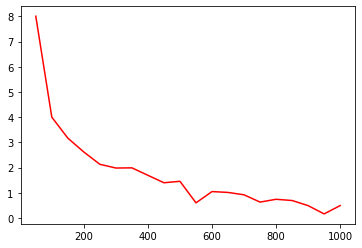

In [66]:
plot_graph(100)

# Overhead over original shuffling with more than one layers computation

In [36]:
def overhead_multiple_layer(no_of_neurons, no_of_layers):
    
    inputs = [random.uniform(-10, 10) for i in range(no_of_neurons)] #random input values
    inputs = np.array(inputs)
    weights = [[] for i in range(no_of_layers)]

    for i in range(no_of_layers):
        W = [[random.uniform(-10, 10) for i in range(no_of_neurons)] for j in range(no_of_neurons)]#random weight values
        weights[i]= W
    
    weights = np.array(weights)

    start_time = time.time()
    layer_inputs = inputs
    for i in range(no_of_layers):
        outputs1 = Fisher_shuffled_one_layer(layer_inputs, weights[i], no_of_neurons, no_of_neurons)
        layer_inputs = outputs1
    end_time = time.time()
    
#     print("original output:")
#     print(outputs1)

    start_time_masked = time.time()
    layer_inputs = inputs
    for i in range(no_of_layers):
         outputs2 = shuffled_one_layer(layer_inputs, weights[i], no_of_neurons, no_of_neurons)
         layer_inputs = outputs2
    end_time_masked = time.time()
    
#     print("output with countermeasure:")
#     print(outputs2)

    t = end_time - start_time
    t_masked = end_time_masked - start_time_masked
    overhead = ((t_masked - t)/t)*100
    

    return overhead

In [37]:
def average_overhead_multiple_layers(number_of_runs, no_of_neurons, no_of_layers):
    overhead = 0
    for i in range(number_of_runs):
        overhead += overhead_multiple_layer(no_of_neurons, no_of_layers)
    overhead /= number_of_runs
    print(overhead)
    return overhead

In [38]:
average_overhead_multiple_layers(100,100,1)

3.2246281053922092


3.2246281053922092

In [43]:
def plot_graph_multiple_layers(number_of_runs, total_layers):
    
    nums = [j for j in range(50,1001,50)]
    length = len(nums)#number of rows in the output file

    for no_of_layers in range(total_layers-1,total_layers):
        print("running for " + str(no_of_layers) + " layers")
        results = []
        for no_of_neurons in nums:
            if(no_of_neurons%100==0):
                print("running for " + str(no_of_neurons))
            overhead = average_overhead_multiple_layers(number_of_runs, no_of_neurons, no_of_layers)
            results.append(overhead)

        f = open("overhead" + str(no_of_layers) + ".txt", "w")
    
        #first line
        f.write("x y\n")
        
        for i in range(length):#for each row
            f.write(str(nums[i])+ " " + str(results[i]) + "\n")
        f.close()
        
        plt.plot(nums,results, color="r")
        
    return

running for 5layers
5.272392464334656
3.8350246710437936
2.7277485842626343
2.1916100249929253
2.530737607464195
1.6274896399358412
1.4172995334955631
1.3317873417261838
0.8586317927534948
0.9886139277830375
1.1874767544139102
1.0593641952092292
0.5226063855338597
0.42839112621999453
0.7362734550872058
0.10061777925646423
-0.4280987560433799
0.42626053148314663
0.5252039164508021
0.35057429450536326
running for 5layers
6.3373728766533555
3.340028364115447
2.3426535162793964
1.9404326484160421
1.548685870461269
1.736127148607484
1.3621749368503004
2.119853554620347
1.5923003696895706
1.9473463342098372
0.8652083547323539
1.957118273639195
1.3562708182049803
0.9262229849491104
0.7337925252658777
0.6548200176269033
5.337604078055046
0.6311897383521159
0.46196586850059435
0.3967087617962823
running for 5layers
7.157737035423444
3.9726924593205832
2.839929237896142
2.2096048791803717
1.7367622064739465
2.392235110959628
1.8180489053317332
1.4920233947919588
1.2409624854643375
0.787211091308

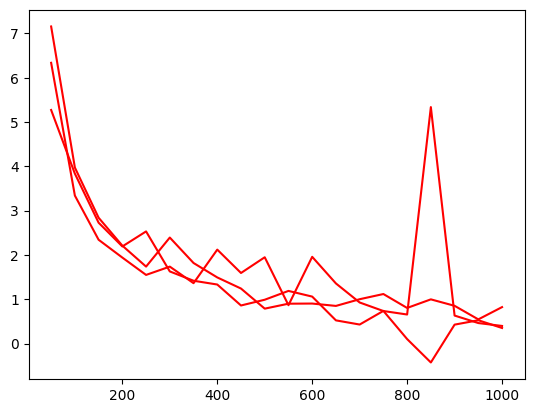

In [42]:
plot_graph_multiple_layers(100, 5)

running for 20layers
7.296263626261026
running for 100
4.205424474564881
3.156227234113598
running for 200
2.490949059356892
1.9827902701130657
running for 300
1.7279724607482054
2.2882793697909074
running for 400
1.5112903087301215
1.196605241122825
running for 500
1.3581505068008792
1.2229248096473342
running for 600
0.943158048629372
0.8656112766805844
running for 700
0.9674316921573732
0.8585272199606717
running for 800
1.103995628830567
0.8742237604268545
running for 900
0.5768335886103817
1.0727341103282315
running for 1000
0.5372164720149974


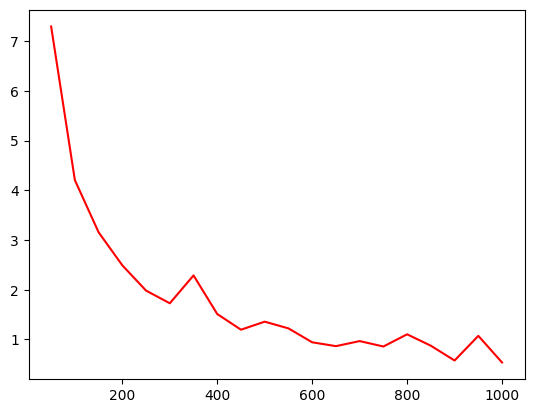

In [45]:
plot_graph_multiple_layers(100, 21)

## Count how many possible values are there in s2

In [67]:
def euler_totient(n):
    # Initialize the count of coprime numbers to 0
    count = 0
    # Iterate from 1 to n-1
    for i in range(1, n):
        # Check if i and n are coprime using gcd
        if math.gcd(i, n) == 1:
            count += 1
    return count

In [68]:
def count_values(neurons):
    prod = 1
    for i in range(3,neurons+1):
        no = euler_totient(i)
        prod *= no
#         print(str(i) + " " + str(no))
    #compute prod = 2^?
    power = math.log2(prod)
    print(power)
    print("\nIn terms of number of years")
    y = prod/(365*24*60*60)
    print("Assuming 1 second for each attak")
    print(math.log2(y))
    
    return

In [69]:
count_values(20)

45.416665599935456

In terms of number of years
Assuming 1 second for each attak
20.50616925422988
